# Comutation plots by brain metastasis status

This notebook generates Figure 4A and Supplementary Figure 4.

# Figure 4A: Paired cohort

In [116]:
import pandas as pd
import numpy as np
import palettable
import matplotlib as mpl
import matplotlib.pyplot as plt

from comut import comut

from scipy.stats import boschloo_exact

In [4]:
# mutations
all_mut_ccfs_maf_annotated = pd.read_csv('data/paired.maf', sep='\t', low_memory=False)

# cohort sheets
participant_cohort_sheet = pd.read_csv('data/paired_participant_cohort_sheet.txt', sep='\t', index_col='participant_id')
sample_cohort_sheet = pd.read_csv('data/paired_sample_cohort_sheet.txt', sep='\t', index_col='collaborator_sample_id')

# metastatic site annotations
met_sites = pd.read_excel('data/TKI Sites of Disease 06142024.xlsx')

# participant ID mapping
id_map = pd.read_csv('data/ONC_ID_to_Manuscript_ID_mapping_paired.txt', sep='\t', index_col='ONC ID')['Manuscript ID'].to_dict()

In [12]:
visceral_met_pts = met_sites.loc[met_sites['Visceral?'].str.contains('Yes'), 'participant_id'].to_list()
brain_met_pts = met_sites.loc[met_sites['Brain/CNS?'].str.contains('Yes'), 'participant_id'].to_list()

In [16]:
participant_list = participant_cohort_sheet.index.tolist()

all_mutations_functional_present_in_post = all_mut_ccfs_maf_annotated[(all_mut_ccfs_maf_annotated['trajectory'] != 'low_ccf') & 
                                                                         (all_mut_ccfs_maf_annotated['mutation_function_updated'] != 0)].copy()

In [17]:
primary_blue = '#377EB8'
dark_blue = '#11508F'
light_blue = '#009DF2'
primary_purple = '#984EA3'
primary_red = '#E41A1C'
primary_orange = '#FF7F00'
primary_yellow = '#FFFF33'
primary_brown = '#A65628'
primary_green = '#4DAF4A'
light_green = '#9FE653'
silent_gray = "#D0D0D0"
darker_gray = '#808080'

# taken from Bang Wong, 'Points of view: Color blindness'
accessible_pink = '#B92E70'  # added from Paul Tol paper
accessible_pink_l = '#CC79A7'
accessible_blue = '#0072B2'
accessible_blue_l = '#56B4E9'
accessible_green = '#009E73'
accessible_orange = '#D55E00'
accessible_orange_l = '#E69F00'
accessible_yellow = '#F0E442'

trajectory_blue = "#2D4C69"   #"#44729D"
trajectory_orange = "#E6993C" #"#D48640"
trajectory_green = "#528F45"  #"#539045"
trajectory_red = "#BD4C57"    #"#B24743"

trajectory_blue_l = "#5690C7"
trajectory_orange_l = "#E6C93C" 
trajectory_green_l = "#6DBD55"  
trajectory_red_l = "#ED5F6D"   

stage_colors = palettable.scientific.sequential.GrayC_16.mpl_colors

In [18]:
default_cols = ['sample', 'category', 'value']

trajectories = ['growing', 'stable_mixed', 'shrinking', 'truncal']
hatches = ['//', '--', '\\\\', None] # horizontal line hatches

In [25]:
# All pathway mutations with evidence level
# Group these into pathways
pathway_combined = all_mutations_functional_present_in_post[all_mutations_functional_present_in_post['level_of_evidence'].notnull()].drop_duplicates(['Patient_ID', 'unique_mut_id']).rename(columns={'Patient_ID': 'sample'})

pathway_combined.loc[pathway_combined['Hugo_Symbol'] == 'ESR1', 'level_of_evidence'] = '2'
pathway_combined['level_of_evidence'] = pathway_combined['level_of_evidence'].astype(str)

pathway_combined['category'] = pathway_combined['gene_set'].replace({'ESR1': 'ESR1 + regulators', 'Cell Cycle': 'Cell cycle'})
pathway_combined['value'] = pathway_combined['trajectory'].apply(lambda x: x if x == 'truncal' else f'subclonal_{x}')
pathway_combined['value'] = pathway_combined['value'] + '_' + pathway_combined['level_of_evidence'].astype(str)

# Separate mutations in TSG and OG in WNT pathway
pathway_wnt_TSG = pathway_combined[(pathway_combined['gene_set'] == 'WNT') & ((pathway_combined['OG/TSG'] == 'TSG'))]
pathway_wnt_TSG.loc[:,'category'] = 'WNT (TSG)'

pathway_wnt_OG = pathway_combined[(pathway_combined['gene_set'] == 'WNT') & (pathway_combined['OG/TSG'] == 'OG')]
pathway_wnt_OG.loc[:,'category'] = 'WNT (OG)'

pathway_combined = pd.concat([pathway_combined, pathway_wnt_TSG, pathway_wnt_OG], ignore_index = True)

pathway_combined.loc[pathway_combined['category'] == 'WNT', 'category'] = 'WNT (all)'

level_colors = [accessible_pink, accessible_orange, accessible_orange_l, accessible_yellow]
trajectories = ['subclonal_growing', 'subclonal_stable_mixed', 'subclonal_shrinking', 'truncal']
pathway_mut_mapping = {}
for t, h in zip(trajectories, hatches):
    for l in ['1','2','3','4']:
        pathway_mut_mapping[t+'_'+l] = {'facecolor': level_colors[int(l)-1], 'hatch': h}

pathway_mut_mapping['Absent'] = silent_gray

/var/folders/x8/btckj2bs3xz_ktydlhbzstb40000gq/T/ipykernel_41708/1161840776.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pathway_wnt_TSG.loc[:,'category'] = 'WNT (TSG)'
/var/folders/x8/btckj2bs3xz_ktydlhbzstb40000gq/T/ipykernel_41708/1161840776.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pathway_wnt_OG.loc[:,'category'] = 'WNT (OG)'


In [81]:
# HR Status
hr_tmp = participant_cohort_sheet.loc[participant_list, ['hr_status']].reset_index().rename(columns={'participant_id': 'sample', 
                                                                                             'hr_status': 'value'})
hr_tmp['category'] = 'HR status'
hr_mapping = {'HR+': accessible_blue, 'HR-': darker_gray}

In [83]:
brain_met_sort_values = pd.DataFrame.from_dict({x: int(x in brain_met_pts) for x in participant_list}, orient = 'index', columns = ['brain_met'])
brain_met_sort_values.index.rename('sample', inplace = True)

brain_met_tmp = brain_met_sort_values.reset_index().rename(columns = {'brain_met': 'value'}).replace({0: 'No', 1: 'Yes'})
brain_met_tmp['category'] = 'Brain met'

In [84]:
visceral_met_sort_values = pd.DataFrame.from_dict({x: int(x in visceral_met_pts) for x in participant_list}, orient = 'index', columns = ['visceral_met'])
visceral_met_sort_values.index.rename('sample', inplace = True)

visceral_met_tmp = visceral_met_sort_values.reset_index().rename(columns = {'visceral_met': 'value'}).replace({0: 'No', 1: 'Yes'})
visceral_met_tmp['category'] = 'Visceral met'

In [110]:
met_mapping = {'Yes': primary_purple, 'No': primary_green}

## Compute Boschloo p value for each pathway and brain / visceral met status

In [111]:
pathway_binary = pathway_combined[['sample', 'category']].pivot_table(index='sample', columns='category', aggfunc='size', fill_value=0).astype('bool').astype('int')
pathway_met_binary = pathway_binary.join(brain_met_sort_values).join(visceral_met_sort_values)

# Brain
boschloo_p = dict()
for c in pathway_binary:
    res = boschloo_exact(pd.crosstab(pathway_met_binary[c], pathway_met_binary['brain_met']).values, alternative = 'greater')
    boschloo_p[c] = -np.log10(res.pvalue)

brain_boschloo_p_plot = pd.Series(boschloo_p).reset_index().rename(columns = {'index': 'category', 0: 'neglogp'}).sort_values('neglogp', ascending = True)

# Visceral
boschloo_p = dict()
for c in pathway_binary:
    res = boschloo_exact(pd.crosstab(pathway_met_binary[c], pathway_met_binary['visceral_met']).values, alternative = 'greater')
    boschloo_p[c] = -np.log10(res.pvalue)

visceral_boschloo_p_plot = pd.Series(boschloo_p).reset_index().rename(columns = {'index': 'category', 0: 'neglogp'}).sort_values('neglogp', ascending = True)

In [112]:
brain_boschloo_p_plot

,category,neglogp
3,MYC,-0.000000
5,PI3K,0.039867
2,HIPPO,0.084202
9,WNT (OG),0.145930
7,TGF-Beta,0.223987
1,ESR1 + regulators,0.252098
6,RTK RAS,0.252098
11,WNT (all),0.374164
4,NOTCH,0.601188
8,TP53,0.601188


In [113]:
visceral_boschloo_p_plot

,category,neglogp
11,WNT (all),0.084859
5,PI3K,0.186598
9,WNT (OG),0.186598
10,WNT (TSG),0.231443
1,ESR1 + regulators,0.240324
2,HIPPO,0.240324
0,Cell cycle,0.372693
3,MYC,0.372693
7,TGF-Beta,0.372693
4,NOTCH,0.693307


## Assemble plot

In [114]:
resistance_plot = comut.CoMut()

# Sort participants by brain met status + time on sampled TKI
participants_sorted = participant_cohort_sheet.loc[participant_list].join(brain_met_sort_values).join(visceral_met_sort_values).sort_values(['brain_met', 'visceral_met'], ascending = False).index

resistance_plot.samples = [id_map[x] for x in participants_sorted]

resistance_plot.add_categorical_data(brain_met_tmp.replace(id_map),
                                     name = 'Brain met',
                                     mapping = met_mapping)

resistance_plot.add_categorical_data(visceral_met_tmp.replace(id_map),
                                     name = 'Visceral met',
                                     mapping = met_mapping)

resistance_plot.add_categorical_data(hr_tmp.replace(id_map), 
                                     name = 'HR status',
                                     mapping = hr_mapping)

pathway_order = brain_boschloo_p_plot['category'].reset_index(drop = True)
pathway_priority = [f'{x}_1' for x in ['subclonal_growing', 'truncal', 'subclonal_stable_mixed', 'subclonal_shrinking']]
pathway_value_order = [f'{x}_{i}' for i in [1,2,3,4] for x in ['subclonal_growing', 'truncal', 'subclonal_stable_mixed', 'subclonal_shrinking']]

resistance_plot.add_categorical_data(pathway_combined[default_cols].drop_duplicates().replace(id_map),
                                     name = 'Cancer pathways',
                                     priority = pathway_priority,
                                     value_order = pathway_value_order,
                                     category_order = pathway_order,
                                     mapping = pathway_mut_mapping)

resistance_plot.add_side_bar_data(brain_boschloo_p_plot,
                                  paired_name = 'Cancer pathways',
                                  name = 'Brain Boschloo p',
                                  position = 'right',
                                  mapping = {'neglogp': darker_gray},
                                  bar_kwargs = {'height': 0.9})

resistance_plot.add_side_bar_data(visceral_boschloo_p_plot,
                                  paired_name = 'Cancer pathways',
                                  name = 'Visceral Boschloo p',
                                  position = 'right',
                                  mapping = {'neglogp': darker_gray},
                                  bar_kwargs = {'height': 0.9})

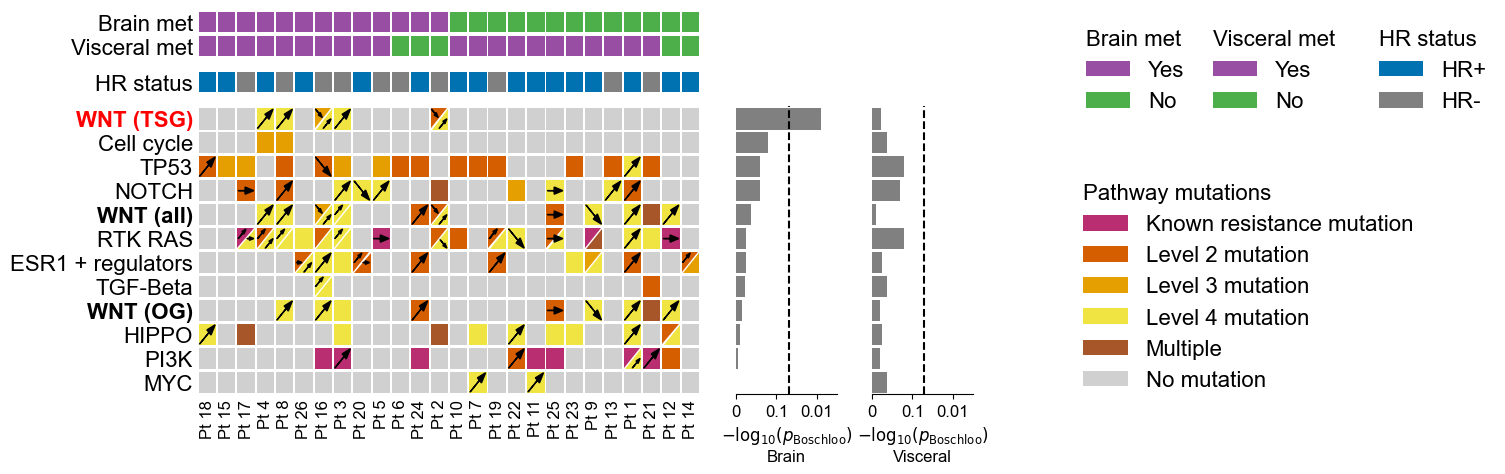

In [115]:
mpl.rcParams['hatch.linewidth'] = 0
mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'

structure = [['Cancer pathways'], ['HR status'], ['Visceral met', 'Brain met']]

resistance_plot.plot_comut(figsize = (10, 5), x_padding = 0.05, y_padding = 0.05, tri_padding = 0.06, hspace = 0.1, structure = structure, subplot_hspace = 0, widths = [5, 1, 1], wspace = 0.15)

for ax in ['Brain Boschloo p', 'Visceral Boschloo p']:
    resistance_plot.axes[ax].set_xlim(0,2.5)
    resistance_plot.axes[ax].set_xticks([0,1,2],[0,0.1,0.01])
    resistance_plot.axes[ax].xaxis.set_tick_params(labelsize = 12)
    resistance_plot.axes[ax].set_xlabel('$-\log_{10}(p_{\mathrm{Boschloo}})$\n' + ax.split()[0], fontsize = 12)
    resistance_plot.axes[ax].axvline(-np.log10(0.05), color = 'k', ls = '--')

resistance_plot.axes['Cancer pathways'].tick_params(axis = 'x', labelsize = 12)

# bold WNT gene sets
resistance_plot.axes['Cancer pathways'].get_yticklabels()[-1].set_weight('bold')
resistance_plot.axes['Cancer pathways'].get_yticklabels()[-5].set_weight('bold')
resistance_plot.axes['Cancer pathways'].get_yticklabels()[-9].set_weight('bold')

resistance_plot.axes['Cancer pathways'].get_yticklabels()[-1].set_color('red')

pathway_legend_ignore = ['subclonal_growing_1', 'subclonal_stable_mixed_1', 'subclonal_shrinking_2', 'subclonal_growing_2', 'subclonal_shrinking_3', 'subclonal_stable_mixed_2', 'subclonal_growing_3', 'subclonal_growing_4', 'subclonal_stable_mixed_4', 'subclonal_shrinking_4']

pathway_legend_rename_dict = {
    'truncal_4': 'Level 4 mutation',
    'truncal_3': 'Level 3 mutation',
    'truncal_2': 'Level 2 mutation',
    'truncal_1': 'Known resistance mutation',
    'Absent': 'No mutation'
}

pathway_legend_order = [
    'Known resistance mutation', 'Level 2 mutation', 'Level 3 mutation', 'Level 4 mutation', 'Multiple', 'No mutation'
]

resistance_plot.add_axis_legend(name = 'Brain met',
                                ncol = 1,
                                title = 'Brain met',
                                order = ['Yes', 'No'],
                                bbox_to_anchor = (2,1))

resistance_plot.add_axis_legend(name = 'Visceral met',
                                ncol = 1,
                                title = 'Visceral met',
                                order = ['Yes', 'No'],
                                bbox_to_anchor = (2.3,2))

resistance_plot.add_axis_legend(name = 'HR status',
                                ncol = 1,
                                title = 'HR status',
                                bbox_to_anchor = (2.6,3.5))

resistance_plot.add_axis_legend(name = 'Cancer pathways',
                                ignored_values = pathway_legend_ignore,
                                ncol = 1,
                                rename = pathway_legend_rename_dict,
                                order = pathway_legend_order,
                                title = 'Pathway mutations',
                                loc = 'upper left',
                                bbox_to_anchor=(1.72, 0.8))

# replacing hatches with arrows - pathways
for i in range(len(participants_sorted)):
    tmp_i = pathway_combined[pathway_combined['sample'] == participants_sorted[i]]
    for j in range(len(pathway_order)):
        tmp_ij = tmp_i[tmp_i['category'] == pathway_order[j]].reset_index()
        if (len(tmp_ij) == 1 and tmp_ij.loc[0, 'trajectory'] != 'truncal') or (len(tmp_ij) == 2 and tmp_ij['trajectory'].nunique() == 1 and ~tmp_ij['trajectory'].str.contains('truncal').any()):
            trj = tmp_ij.loc[0, 'trajectory']
            if trj == 'growing':
                resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.1, y = j + 0.1, dx = 0.8, dy = 0.8, head_width = 0.3, length_includes_head = True, zorder = 2, color = 'black')
            elif trj == 'shrinking':
                resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.1, y = j + 0.9, dx = 0.8, dy = -0.8, head_width = 0.3, length_includes_head = True, zorder = 2, color = 'black')
            elif trj == 'stable_mixed':
                resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.1, y = j + 0.5, dx = 0.8, dy = 0, head_width = 0.3, length_includes_head = True, zorder = 2, color = 'black')
        elif len(tmp_ij) == 2:
            tmp_ij['value_categ'] = pd.Categorical(tmp_ij['value'], ordered = True, categories = pathway_value_order)
            tmp_ij = tmp_ij.sort_values('value_categ').reset_index()
            for k, row in tmp_ij.iterrows():
                trj = row['trajectory']
                if k == 0: # left triangle
                    if trj == 'growing':
                        resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.1, y = j + 0.5, dx = 0.4, dy = 0.4, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
                    elif trj == 'shrinking':
                        resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.1, y = j + 0.9, dx = 0.35, dy = -0.35, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
                    elif trj == 'stable_mixed':
                        resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.1, y = j + 0.5, dx = 0.3, dy = 0, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
                else: # right triangle
                    if trj == 'growing':
                        resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.5, y = j + 0.1, dx = 0.4, dy = 0.4, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
                    elif trj == 'shrinking':
                        resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.55, y = j + 0.45, dx = 0.35, dy = -0.35, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
                    elif trj == 'stable_mixed':
                        resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.55, y = j + 0.5, dx = 0.35, dy = 0, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
        elif tmp_ij['value'].nunique() == 2:
            trjs = sorted(list(set(tmp_ij['value'].unique())), key = pathway_value_order.index)
            for k, trj in enumerate(trjs):
                if k == 0: # left triangle
                    if 'growing' in trj:
                        resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.1, y = j + 0.5, dx = 0.4, dy = 0.4, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
                    elif 'shrinking' in trj:
                        resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.1, y = j + 0.9, dx = 0.35, dy = -0.35, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
                    elif 'stable_mixed' in trj:
                        resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.1, y = j + 0.5, dx = 0.3, dy = 0, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
                else: # right triangle
                    if 'growing' in trj:
                        resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.5, y = j + 0.1, dx = 0.4, dy = 0.4, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
                    elif 'shrinking' in trj:
                        resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.55, y = j + 0.45, dx = 0.35, dy = -0.35, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')
                    elif 'stable_mixed' in trj:
                        resistance_plot.axes['Cancer pathways'].arrow(x = i + 0.55, y = j + 0.5, dx = 0.35, dy = 0, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')

# edge case - level 1 mutation (prioritized) with multiple others
resistance_plot.axes['Cancer pathways'].arrow(x = 15 + 0.1, y = 6 + 0.5, dx = 0.4, dy = 0.4, head_width = 0.15, length_includes_head = True, zorder = 2, color = 'black')

plt.show()

# Unpaired cohort

In [117]:
# mutations
all_mut_ccfs_maf_annotated = pd.read_csv('data/unpaired.maf', sep='\t', low_memory=False)

# cohort sheets
participant_cohort_sheet = pd.read_csv('data/unpaired_participant_cohort_sheet.txt', sep='\t', index_col='participant_id')
sample_cohort_sheet = pd.read_csv('data/unpaired_sample_cohort_sheet.txt', sep='\t', index_col=0)

# metastatic site annotations
met_sites = pd.read_excel('data/TKI Unpaired Sites of Disease Deidentified 07292024.xlsx')

# participant ID mapping
id_map = pd.read_csv('data/ONC_ID_to_Manuscript_ID_mapping_unpaired.txt', sep='\t', index_col='ONC ID')['Manuscript ID'].to_dict()

In [121]:
visceral_met_pts = met_sites.loc[met_sites['Visceral?'].str.contains('Yes'), 'ONC ID'].to_list()
brain_met_pts = met_sites.loc[met_sites['Brain/CNS?'].str.contains('Yes'), 'ONC ID'].to_list()

In [122]:
participant_list = participant_cohort_sheet.index.tolist()
participant_list_pre = participant_cohort_sheet[participant_cohort_sheet['Cohort'] == 'Non-exposed'].index.tolist()
participant_list_post = participant_cohort_sheet[participant_cohort_sheet['Cohort'] == 'Exposed'].index.tolist()

all_mutations_functional = all_mut_ccfs_maf_annotated[(all_mut_ccfs_maf_annotated['mutation_function_updated'] != 0) &
                                                      (all_mut_ccfs_maf_annotated['postDP_ccf_mode'] >= 0.1)].copy()

In [123]:
# All pathway mutations with evidence level
# Group these into pathways
pathway_combined = all_mutations_functional[all_mutations_functional['level_of_evidence'].astype(str).isin(['1','2','3','4','Separate ESR1 Mutation'])].drop_duplicates(['Patient_ID', 'unique_mut_id']).rename(columns={'Patient_ID': 'sample'})

# Need to update these in prepare_mutations_general
pathway_combined.loc[pathway_combined['Hugo_Symbol'] == 'ESR1', 'level_of_evidence'] = 2
pathway_combined.loc[pathway_combined['Hugo_Symbol'] == 'LZTR1', 'OG/TSG'] = 'TSG'
pathway_combined.loc[pathway_combined['Hugo_Symbol'] == 'CHD8', 'OG/TSG'] = 'TSG'

pathway_combined['category'] = pathway_combined['gene_set'].replace({'ESR1': 'ESR1 + regulators', 'Cell Cycle': 'Cell cycle'})
pathway_combined['value'] = pathway_combined['clonal_status'] + '_' + pathway_combined['level_of_evidence'].astype(str)

# Separate mutations in TSG and OG in WNT pathway
pathway_wnt_TSG = pathway_combined[(pathway_combined['gene_set'] == 'WNT') & ((pathway_combined['OG/TSG'] == 'TSG'))]
pathway_wnt_TSG.loc[:,'category'] = 'WNT (TSG)'

pathway_wnt_OG = pathway_combined[(pathway_combined['gene_set'] == 'WNT') & (pathway_combined['OG/TSG'] == 'OG')]
pathway_wnt_OG.loc[:,'category'] = 'WNT (OG)'

pathway_combined = pd.concat([pathway_combined, pathway_wnt_TSG, pathway_wnt_OG], ignore_index = True)

pathway_combined.loc[pathway_combined['category'] == 'WNT', 'category'] = 'WNT (all)'

pathway_combined_pre = pathway_combined[pathway_combined['sample'].isin(participant_list_pre)]
pathway_combined_post = pathway_combined[pathway_combined['sample'].isin(participant_list_post)]

level_colors = [accessible_pink, accessible_orange, accessible_orange_l, accessible_yellow]
pathway_mut_mapping = {}
for t, h in zip(['clonal', 'subclonal'], [None, 'xxx']):
    for l in ['1','2','3','4']:
        pathway_mut_mapping[t+'_'+l] = {'facecolor': level_colors[int(l)-1], 'hatch': h}

pathway_mut_mapping['Absent'] = silent_gray

/var/folders/x8/btckj2bs3xz_ktydlhbzstb40000gq/T/ipykernel_41708/3966548902.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pathway_wnt_TSG.loc[:,'category'] = 'WNT (TSG)'
/var/folders/x8/btckj2bs3xz_ktydlhbzstb40000gq/T/ipykernel_41708/3966548902.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pathway_wnt_OG.loc[:,'category'] = 'WNT (OG)'


In [127]:
# HR Status
hr_tmp = participant_cohort_sheet.loc[participant_list, ['hr_status']].reset_index().rename(columns={'participant_id': 'sample', 
                                                                                             'hr_status': 'value'})
hr_tmp['category'] = 'HR status'
hr_mapping = {'HR+': accessible_blue, 'HR-': darker_gray, 'HR Unknown': silent_gray}

In [137]:
brain_met_sort_values = pd.DataFrame.from_dict({x: int(x in brain_met_pts) for x in participant_list}, orient = 'index', columns = ['brain_met'])
brain_met_sort_values.index.rename('sample', inplace = True)

brain_met_tmp = met_sites.rename(columns = {'ONC ID': 'sample', 'Brain/CNS?': 'value'})
brain_met_tmp['category'] = 'Brain met'
brain_met_tmp = brain_met_tmp[['sample', 'value', 'category']]

In [139]:
visceral_met_sort_values = pd.DataFrame.from_dict({x: int(x in visceral_met_pts) for x in participant_list}, orient = 'index', columns = ['visceral_met'])
visceral_met_sort_values.index.rename('sample', inplace = True)

visceral_met_tmp = met_sites.rename(columns = {'ONC ID': 'sample', 'Visceral?': 'value'})
visceral_met_tmp['category'] = 'Visceral met'
visceral_met_tmp = visceral_met_tmp[['sample', 'value', 'category']]

In [141]:
met_mapping = {'Yes': primary_purple, 'No': primary_green, 'Unknown': silent_gray}

## Compute Boschloo p value for each pathway and brain / visceral met status

In [169]:
brain_met_old = pd.concat([pd.read_excel('data/pre_tki_brain_mets.xlsx'), pd.read_excel('data/post_tki_brain_mets.xlsx')]).\
    set_index('participant_id').\
    rename(columns={'Ever brain met?': 'Previous annotation'}).\
    drop(columns = 'Unnamed: 1')

brain_met_comparison = brain_met_old.join(brain_met_tmp.set_index('sample').rename(columns = {'value': 'Current annotation'}).drop(columns = 'category'))
brain_met_comparison

,Previous annotation,Current annotation
participant_id,,
ONC103614,No,No
ONC106597,No,No
ONC108446,Unclear,Yes
ONC110561,Unclear,Unknown
ONC111170,Yes,Yes
...,...,...
ONC73160,Yes,Yes
ONC77838,Yes,Yes
ONC86963,Yes,Yes


In [171]:
brain_met_comparison.to_excel('/Users/jweiss/Downloads/brain_met_comparison.xlsx')

In [111]:
pathway_binary = pathway_combined[['sample', 'category']].pivot_table(index='sample', columns='category', aggfunc='size', fill_value=0).astype('bool').astype('int')
pathway_met_binary = pathway_binary.join(brain_met_sort_values).join(visceral_met_sort_values)

# Brain
boschloo_p = dict()
for c in pathway_binary:
    res = boschloo_exact(pd.crosstab(pathway_met_binary[c], pathway_met_binary['brain_met']).values, alternative = 'greater')
    boschloo_p[c] = -np.log10(res.pvalue)

brain_boschloo_p_plot = pd.Series(boschloo_p).reset_index().rename(columns = {'index': 'category', 0: 'neglogp'}).sort_values('neglogp', ascending = True)

# Visceral
boschloo_p = dict()
for c in pathway_binary:
    res = boschloo_exact(pd.crosstab(pathway_met_binary[c], pathway_met_binary['visceral_met']).values, alternative = 'greater')
    boschloo_p[c] = -np.log10(res.pvalue)

visceral_boschloo_p_plot = pd.Series(boschloo_p).reset_index().rename(columns = {'index': 'category', 0: 'neglogp'}).sort_values('neglogp', ascending = True)

In [112]:
brain_boschloo_p_plot

,category,neglogp
3,MYC,-0.000000
5,PI3K,0.039867
2,HIPPO,0.084202
9,WNT (OG),0.145930
7,TGF-Beta,0.223987
1,ESR1 + regulators,0.252098
6,RTK RAS,0.252098
11,WNT (all),0.374164
4,NOTCH,0.601188
8,TP53,0.601188


In [113]:
visceral_boschloo_p_plot

,category,neglogp
11,WNT (all),0.084859
5,PI3K,0.186598
9,WNT (OG),0.186598
10,WNT (TSG),0.231443
1,ESR1 + regulators,0.240324
2,HIPPO,0.240324
0,Cell cycle,0.372693
3,MYC,0.372693
7,TGF-Beta,0.372693
4,NOTCH,0.693307


In [16]:
# Brain met status

# Pre
brain_met_sort_values_pre = pd.DataFrame.from_dict({x: int(x in brain_met_pts_pre) for x in participant_list_pre}, orient = 'index', columns = ['brain_met'])
brain_met_sort_values_pre.index.rename('sample', inplace = True)

brain_met_tmp_pre = brain_met_sort_values_pre.reset_index().rename(columns = {'brain_met': 'value'}).replace({0: 'No', 1: 'Yes'})
brain_met_tmp_pre['category'] = 'Brain met'

# Post
brain_met_sort_values_post = pd.DataFrame.from_dict({x: int(x in brain_met_pts_post) for x in participant_list_post}, orient = 'index', columns = ['brain_met'])
brain_met_sort_values_post.index.rename('sample', inplace = True)

brain_met_tmp_post = brain_met_sort_values_post.reset_index().rename(columns = {'brain_met': 'value'}).replace({0: 'No', 1: 'Yes'})
brain_met_tmp_post['category'] = 'Brain met'

## Compute Boschloo p value for each pathway

In [17]:
# Pre
pathway_binary_pre = pathway_combined_pre[['sample', 'category']].pivot_table(index='sample', columns='category', aggfunc='size', fill_value=0).astype('bool').astype('int')
pathway_brainmet_binary_pre = pathway_binary_pre.merge(brain_met_sort_values_pre, left_index=True, right_index=True, how='right').fillna(0)
boschloo_p_pre = dict()
for c in pathway_binary_pre:
    res = boschloo_exact(pd.crosstab(pathway_brainmet_binary_pre[c], pathway_brainmet_binary_pre['brain_met']).values, alternative = 'greater')
    boschloo_p_pre[c] = -np.log10(res.pvalue)
boschloo_p_plot_pre = pd.Series(boschloo_p_pre).reset_index().rename(columns = {'index': 'category', 0: 'neglogp'}).sort_values('neglogp', ascending = True)

# Post
pathway_binary_post = pathway_combined_post[['sample', 'category']].pivot_table(index='sample', columns='category', aggfunc='size', fill_value=0).astype('bool').astype('int')
pathway_brainmet_binary_post = pathway_binary_post.merge(brain_met_sort_values_post, left_index=True, right_index=True, how='right').fillna(0)
boschloo_p_post = dict()
for c in pathway_binary_post:
    res = boschloo_exact(pd.crosstab(pathway_brainmet_binary_post[c], pathway_brainmet_binary_post['brain_met']).values, alternative = 'greater')
    boschloo_p_post[c] = -np.log10(res.pvalue)
boschloo_p_plot_post = pd.Series(boschloo_p_post).reset_index().rename(columns = {'index': 'category', 0: 'neglogp'}).sort_values('neglogp', ascending = True)

# Combined
pathway_binary = pathway_combined[['sample', 'category']].pivot_table(index='sample', columns='category', aggfunc='size', fill_value=0).astype('bool').astype('int')
pathway_brainmet_binary = pathway_binary.merge(pd.concat([brain_met_sort_values_pre, brain_met_sort_values_post]), left_index=True, right_index=True, how='right').fillna(0)
boschloo_p = dict()
for c in pathway_binary:
    res = boschloo_exact(pd.crosstab(pathway_brainmet_binary[c], pathway_brainmet_binary['brain_met']).values, alternative = 'greater')
    boschloo_p[c] = -np.log10(res.pvalue)
boschloo_p_plot = pd.Series(boschloo_p).reset_index().rename(columns = {'index': 'category', 0: 'neglogp'}).sort_values('neglogp', ascending = True)

## Assemble plot

### Pre-TKI cohort

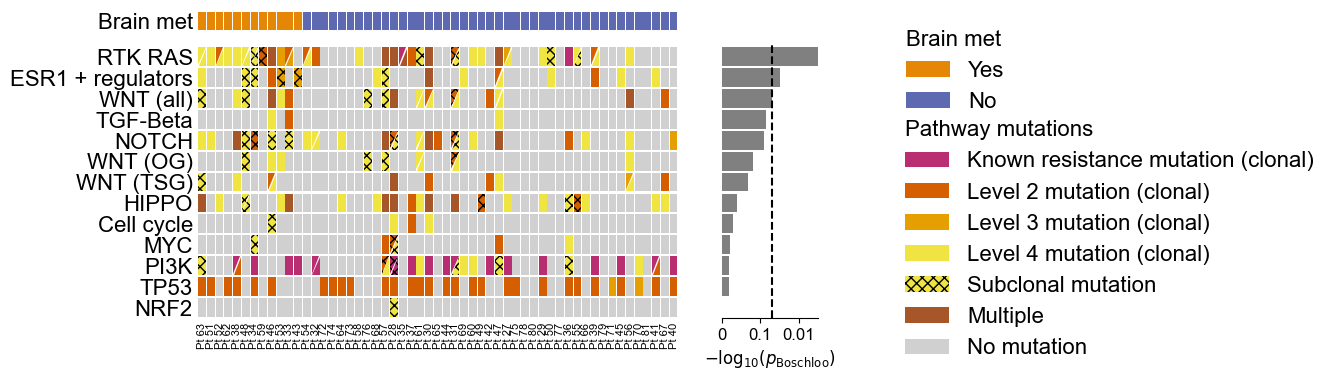

In [18]:
resistance_plot = comut.CoMut()

# Sort participants by brain met status + time on TKI
participants_sorted_pre = participant_cohort_sheet.loc[participant_list_pre].join(brain_met_sort_values_pre).sort_values(['brain_met', 'earliest_tki_duration'], ascending = False).index

resistance_plot.samples = [id_map[x] for x in participants_sorted_pre]

resistance_plot.add_categorical_data(brain_met_tmp_pre.replace(id_map),
                                     name = 'Brain met')

pathway_order = boschloo_p_plot_pre['category'].reset_index(drop = True)
pathway_priority = [f'{x}_1' for x in ['clonal', 'subclonal']]
pathway_value_order = [f'{x}_{i}' for i in [1,2,3,4] for x in ['clonal', 'subclonal']]

resistance_plot.add_categorical_data(pathway_combined_pre[default_cols].replace(id_map),
                                     name = 'Cancer pathways',
                                     priority = pathway_priority,
                                     value_order = pathway_value_order,
                                     category_order = pathway_order,
                                     mapping = pathway_mut_mapping)

resistance_plot.add_side_bar_data(boschloo_p_plot_pre,
                                  paired_name = 'Cancer pathways',
                                  name = 'Boschloo p',
                                  xlabel = '$-\log_{10}(p_{\mathrm{Boschloo}})$',
                                  position = 'right',
                                  mapping = {'neglogp': darker_gray},
                                  bar_kwargs = {'height': 0.9})

mpl.rcParams['hatch.linewidth'] = 1
mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'

structure = [['Cancer pathways'], ['Brain met']]

resistance_plot.plot_comut(figsize = (8, 4), x_padding = 0.05, y_padding = 0.05, tri_padding = 0.06, hspace = 0.1, structure = structure, subplot_hspace = 0, widths = [5, 1], wspace = 0.15)

resistance_plot.axes['Boschloo p'].set_xlim(0,2.5)
resistance_plot.axes['Boschloo p'].set_xticks([0,1,2],[0,0.1,0.01])
resistance_plot.axes['Boschloo p'].xaxis.set_tick_params(labelsize = 12)
resistance_plot.axes['Boschloo p'].set_xlabel('$-\log_{10}(p_{\mathrm{Boschloo}})$', fontsize = 12)
resistance_plot.axes['Boschloo p'].axvline(-np.log10(0.05), color = 'k', ls = '--')

resistance_plot.axes['Cancer pathways'].tick_params(axis = 'x', labelsize = 8)

pathway_legend_ignore = ['subclonal_1', 'subclonal_2', 'subclonal_3']

pathway_legend_rename_dict = {
    'clonal_1': 'Known resistance mutation (clonal)',
    'clonal_2': 'Level 2 mutation (clonal)',
    'clonal_3': 'Level 3 mutation (clonal)',
    'clonal_4': 'Level 4 mutation (clonal)',
    'subclonal_4': 'Subclonal mutation',
    'Absent': 'No mutation'
}

pathway_legend_order = [
    'Known resistance mutation (clonal)', 'Level 2 mutation (clonal)', 'Level 3 mutation (clonal)', 'Level 4 mutation (clonal)',
    'Subclonal mutation', 'Multiple', 'No mutation'
]

resistance_plot.add_axis_legend(name = 'Brain met',
                                ncol = 1,
                                title = 'Brain met',
                                order = ['Yes', 'No'],
                                bbox_to_anchor = (1.72,1))

resistance_plot.add_axis_legend(name = 'Cancer pathways',
                                ignored_values = pathway_legend_ignore,
                                ncol = 1,
                                rename = pathway_legend_rename_dict,
                                order = pathway_legend_order,
                                title = 'Pathway mutations',
                                bbox_to_anchor=(1.43, 0.8))
plt.show()

### Post-TKI cohort

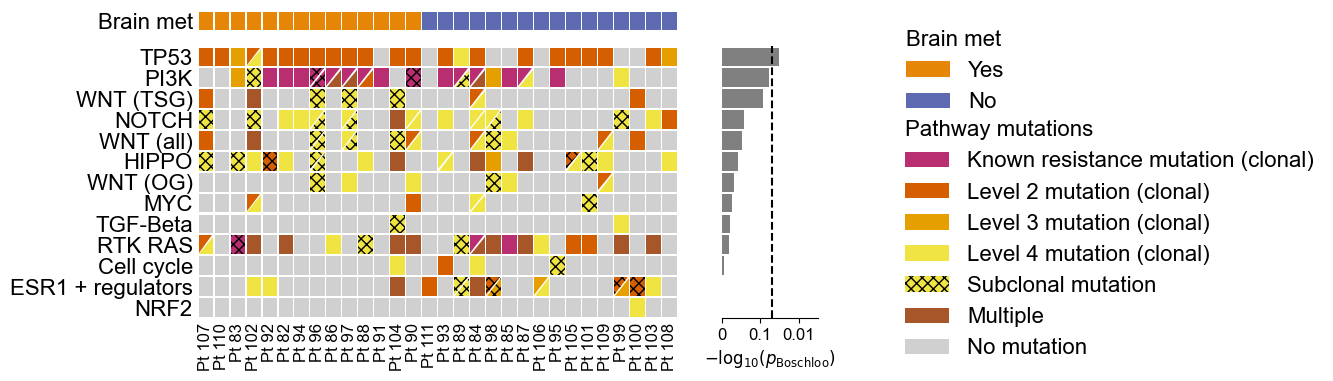

In [19]:
resistance_plot = comut.CoMut()

# Sort participants by brain met status + time on TKI
participants_sorted_post = participant_cohort_sheet.loc[participant_list_post].join(brain_met_sort_values_post).sort_values(['brain_met', 'earliest_tki_duration'], ascending = False).index

resistance_plot.samples = [id_map[x] for x in participants_sorted_post]

resistance_plot.add_categorical_data(brain_met_tmp_post.replace(id_map),
                                     name = 'Brain met')

pathway_order = boschloo_p_plot_post['category'].reset_index(drop = True)
pathway_priority = [f'{x}_1' for x in ['clonal', 'subclonal']]
pathway_value_order = [f'{x}_{i}' for i in [1,2,3,4] for x in ['clonal', 'subclonal']]

resistance_plot.add_categorical_data(pathway_combined_post[default_cols].replace(id_map),
                                     name = 'Cancer pathways',
                                     priority = pathway_priority,
                                     value_order = pathway_value_order,
                                     category_order = pathway_order,
                                     mapping = pathway_mut_mapping)

resistance_plot.add_side_bar_data(boschloo_p_plot_post,
                                  paired_name = 'Cancer pathways',
                                  name = 'Boschloo p',
                                  xlabel = '$-\log_{10}(p_{\mathrm{Boschloo}})$',
                                  position = 'right',
                                  mapping = {'neglogp': darker_gray},
                                  bar_kwargs = {'height': 0.9})

mpl.rcParams['hatch.linewidth'] = 1
mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'

structure = [['Cancer pathways'], ['Brain met']]

resistance_plot.plot_comut(figsize = (8, 4), x_padding = 0.05, y_padding = 0.05, tri_padding = 0.06, hspace = 0.1, structure = structure, subplot_hspace = 0, widths = [5, 1], wspace = 0.15)

resistance_plot.axes['Boschloo p'].set_xlim(0,2.5)
resistance_plot.axes['Boschloo p'].set_xticks([0,1,2],[0,0.1,0.01])
resistance_plot.axes['Boschloo p'].xaxis.set_tick_params(labelsize = 12)
resistance_plot.axes['Boschloo p'].set_xlabel('$-\log_{10}(p_{\mathrm{Boschloo}})$', fontsize = 12)
resistance_plot.axes['Boschloo p'].axvline(-np.log10(0.05), color = 'k', ls = '--')

resistance_plot.axes['Cancer pathways'].tick_params(axis = 'x', labelsize = 12)

pathway_legend_ignore = ['subclonal_1', 'subclonal_2', 'subclonal_3']

pathway_legend_rename_dict = {
    'clonal_1': 'Known resistance mutation (clonal)',
    'clonal_2': 'Level 2 mutation (clonal)',
    'clonal_3': 'Level 3 mutation (clonal)',
    'clonal_4': 'Level 4 mutation (clonal)',
    'subclonal_4': 'Subclonal mutation',
    'Absent': 'No mutation'
}

pathway_legend_order = [
    'Known resistance mutation (clonal)', 'Level 2 mutation (clonal)', 'Level 3 mutation (clonal)', 'Level 4 mutation (clonal)',
    'Subclonal mutation', 'Multiple', 'No mutation'
]

resistance_plot.add_axis_legend(name = 'Brain met',
                                ncol = 1,
                                title = 'Brain met',
                                order = ['Yes', 'No'],
                                bbox_to_anchor = (1.72,1))

resistance_plot.add_axis_legend(name = 'Cancer pathways',
                                ignored_values = pathway_legend_ignore,
                                ncol = 1,
                                rename = pathway_legend_rename_dict,
                                order = pathway_legend_order,
                                title = 'Pathway mutations',
                                bbox_to_anchor=(1.43, 0.8))
plt.show()

### Supplementary Figure 4: Combined pre- and post-TKI unpaired cohort

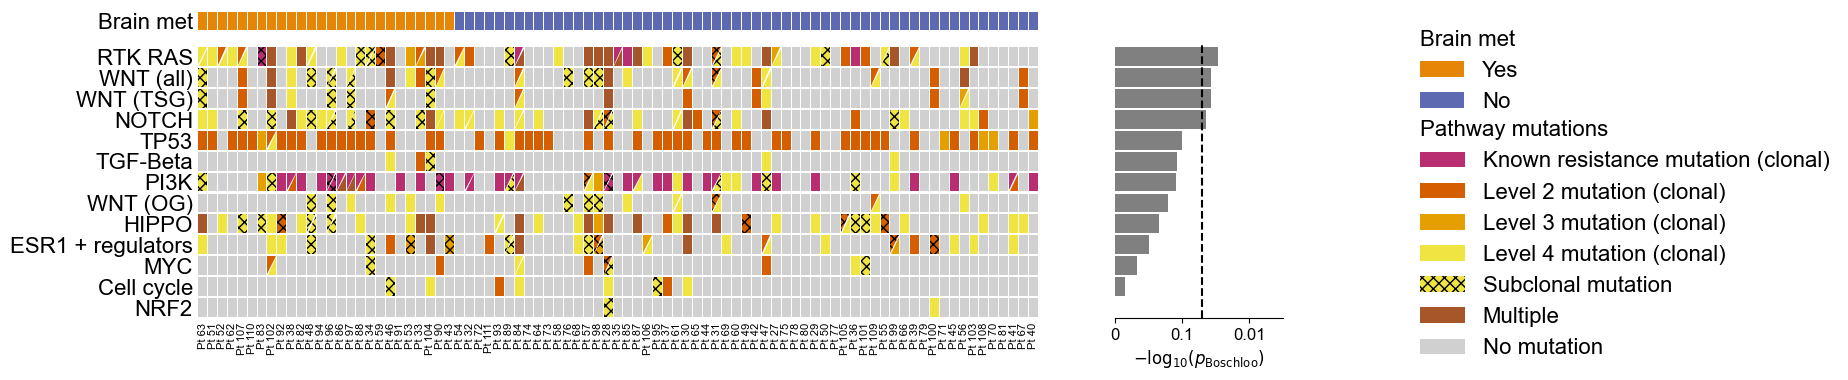

In [20]:
resistance_plot = comut.CoMut()

# Sort participants by brain met status + time on TKI
participants_sorted = participant_cohort_sheet.loc[participant_list].join(pd.concat([brain_met_sort_values_pre, brain_met_sort_values_post])).sort_values(['brain_met', 'earliest_tki_duration'], ascending = False).index

resistance_plot.samples = [id_map[x] for x in participants_sorted]

resistance_plot.add_categorical_data(pd.concat([brain_met_tmp_pre, brain_met_tmp_post]).replace(id_map),
                                     name = 'Brain met')

pathway_order = boschloo_p_plot['category'].reset_index(drop = True)
pathway_priority = [f'{x}_1' for x in ['clonal', 'subclonal']]
pathway_value_order = [f'{x}_{i}' for i in [1,2,3,4] for x in ['clonal', 'subclonal']]

resistance_plot.add_categorical_data(pathway_combined[default_cols].replace(id_map),
                                     name = 'Cancer pathways',
                                     priority = pathway_priority,
                                     value_order = pathway_value_order,
                                     category_order = pathway_order,
                                     mapping = pathway_mut_mapping)

resistance_plot.add_side_bar_data(boschloo_p_plot,
                                  paired_name = 'Cancer pathways',
                                  name = 'Boschloo p',
                                  xlabel = '$-\log_{10}(p_{\mathrm{Boschloo}})$',
                                  position = 'right',
                                  mapping = {'neglogp': darker_gray},
                                  bar_kwargs = {'height': 0.9})

mpl.rcParams['hatch.linewidth'] = 1
mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'

structure = [['Cancer pathways'], ['Brain met']]

resistance_plot.plot_comut(figsize = (14, 4), x_padding = 0.05, y_padding = 0.05, tri_padding = 0.06, hspace = 0.1, structure = structure, subplot_hspace = 0, widths = [5, 1], wspace = 0.15)

resistance_plot.axes['Boschloo p'].set_xlim(0,2.5)
resistance_plot.axes['Boschloo p'].set_xticks([0,1,2],[0,0.1,0.01])
resistance_plot.axes['Boschloo p'].xaxis.set_tick_params(labelsize = 12)
resistance_plot.axes['Boschloo p'].set_xlabel('$-\log_{10}(p_{\mathrm{Boschloo}})$', fontsize = 12)
resistance_plot.axes['Boschloo p'].axvline(-np.log10(0.05), color = 'k', ls = '--')

resistance_plot.axes['Cancer pathways'].tick_params(axis = 'x', labelsize = 8)

pathway_legend_ignore = ['subclonal_1', 'subclonal_2', 'subclonal_3']

pathway_legend_rename_dict = {
    'clonal_1': 'Known resistance mutation (clonal)',
    'clonal_2': 'Level 2 mutation (clonal)',
    'clonal_3': 'Level 3 mutation (clonal)',
    'clonal_4': 'Level 4 mutation (clonal)',
    'subclonal_4': 'Subclonal mutation',
    'Absent': 'No mutation'
}

pathway_legend_order = [
    'Known resistance mutation (clonal)', 'Level 2 mutation (clonal)', 'Level 3 mutation (clonal)', 'Level 4 mutation (clonal)',
    'Subclonal mutation', 'Multiple', 'No mutation'
]

resistance_plot.add_axis_legend(name = 'Brain met',
                                ncol = 1,
                                title = 'Brain met',
                                order = ['Yes', 'No'],
                                bbox_to_anchor = (1.594,1))

resistance_plot.add_axis_legend(name = 'Cancer pathways',
                                ignored_values = pathway_legend_ignore,
                                ncol = 1,
                                rename = pathway_legend_rename_dict,
                                order = pathway_legend_order,
                                title = 'Pathway mutations',
                                bbox_to_anchor=(1.43, 0.8))
plt.show()

In [21]:
np.round(10**(-boschloo_p['WNT (TSG)']), 3)

0.037